In [3]:
running_on_kaggle = True

if running_on_kaggle:
    # Kaggle does not automatically have this
    !pip install torch_geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00a 0:00:01


In [4]:
import os
import sys
from tqdm import tqdm
from datetime import datetime
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch

In [5]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

if running_on_kaggle:
    train_file = np.load("/kaggle/input/cse-251-b-2025/train.npz")
    test_file = np.load("/kaggle/input/cse-251-b-2025/test_input.npz")
else:
    train_file = np.load("./cse-251-b-2025/train.npz")
    test_file = np.load("./cse-251-b-2025/test_input.npz")

train_data = train_file['data']
test_data = test_file['data']

print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

In [6]:
# Run visualizations?
run_visualizations: bool = False

# From data loading notebook
def plot_one_training_scene(idx: int = 0):
    # Plot trajectories from one training scene (static plot)
    data_matrix = train_data[idx]

    plt.figure(figsize=(8, 8))
    for agent in range(data_matrix.shape[idx]):
        xs = data_matrix[agent, :, 0]
        ys = data_matrix[agent, :, 1]
        # Remove zeros (padding)
        xs = xs[xs != 0]
        ys = ys[ys != 0]
        plt.plot(xs, ys, alpha=0.7)
    plt.title("Trajectories from one training scene")
    plt.xlabel("x-coordinate")
    plt.ylabel("y-coordinate")
    plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

if run_visualizations:
    plot_one_training_scene(0)
    make_gif(train_data[0], 'index0')

# Constant velocity from test set
Untouched from original data loading notebook.

In [7]:
# Run constant velocity model (Kaggle score of ~50)?
run_constant_velocity_model: bool = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Our Work

In [8]:
# MLP model with residual blocks: ineffective for TimeSeries data
class BasicMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()

        # Lazy layers infer the input size instead of having to explicitly pass it in
        # Backbone: linear -> BatchNorm -> PReLU -> Dropout
        self.net = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.2),
        ) # Note: residual width must match the last width of the net

        # Residual block added to avoid vanishing gradient issue
        self.residual = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(256),
        )

        # Infer last input shape, then do final projection (60*2)
        self.head = nn.LazyLinear(output_features)

    def forward(self, x):
        # Original forward loop
        # # (batch, 50, 50, 6) or flattened already
        # x = x.view(x.size(0), -1)
        # h = self.net(x) #(batch, 256)
        # h = h + self.residual(h)  # residual skip
        # return self.head(h) #(batch, 120)

        # Taken from milestone notebook (tensor format)
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.net(x)
        x = x + self.residual(x)
        x = self.head(x)
        return x.view(-1, 60, 2)

In [9]:
# Base LSTM given to us in the milestone notebook
class BaseLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [10]:
# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):
        # x = data.x
        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        # x = x.reshape(-1, 50 * 50 * 6)
        # x = self.mlp(x)
        # return x.view(-1, 60, 2)
        # In case you passed in a DataBatch
        if not isinstance(x_flat, torch.Tensor):
            x_flat = x_flat.x

        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)

        out = self.decoder(combined) #(B, 120)
        return out.view(-1, 60, 2)

In [11]:
# Extended from the base LSTM model
class LSTMWithMLP(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        x = self.net(lstm_out[:, -1, :])
        x = self.fc(x)
        return x.view(-1, 60, 2)

In [12]:
class LSTMButTwo(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        self.second_out_dim = 128

        self.lstm_1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)

        self.residual = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, self.second_out_dim),
        )
        
        self.lstm_2 = nn.LSTM(hidden_dim, self.second_out_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(self.second_out_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_first_out, _ = self.lstm_1(x)
        residual = self.residual(lstm_first_out)
        lstm_second_out, _ = self.lstm_2(lstm_first_out)
        lstm_plus_res = lstm_second_out + residual

        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        lstm_out = lstm_plus_res[:, -1, :]
        x = self.fc(lstm_out)
        return x.view(-1, 60, 2)

In [13]:
# Coded with assistance from ChatGPT 4o to understand the attention mechanism stated in
# the paper "Time Series Prediction Based on LSTM-Attention-LSTM Model" along with noting
# the dimensions after each operation. Deepseek was also used to help with dimension issues,
# such as when to squeeze/unsqueeze, especially debugging the decoder LSTM.
class LSTMAttLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        
        # Encoder: encodes input dimensions into hidden
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)

        # Decoder: another LSTM layer that decodes the encoder's hidden state
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)

        # Output
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        # Only consider Ego agent at index 0 -> (batch_size, seq_len, input_dim)
        x = x[:, 0, :, :] # Can adjust how much of the sequence to consider
        # B, L, D = x.shape

        # nn.LSTM: # enc_out: (B, L, H), h_n: (D*num_layers, B, H)
        encoder_out, (h_n, c_n) = self.encoder(x)

        # Last hidden state: (B, H)
        h_n_last = h_n[-1]

        # "Attention correlations"
        # Unsqueeze -> extend a dimension (so the matrix multiplication works)
        # torch.bmm -> matrix multiplication/dot product across batches
        # Squeeze -> contract a dimension (remove the previous phantom dimension)
        # e: (B, L)
        e = torch.bmm(encoder_out, h_n_last.unsqueeze(2)).squeeze(2)

        # Attention weights: (B, L)
        alpha = F.softmax(e, dim=1) # dim=1 to go along seq_len

        # Context vector: (B, H)
        # Unsqueeze alpha to (B, 1, L) to matrixmul into encoder (B, L, H)
        # Squeeze the expanded dimension to reach (B, H)
        context = torch.bmm(alpha.unsqueeze(1), encoder_out).squeeze(1)

        # Decoder: pass in the encoder's last hidden state (h_i)
        # Unsqueeze context to a "one-step" sequence
        context = context.unsqueeze(1)  # (B, 1, H)
        decoder_h0 = h_n[-1].unsqueeze(0)  # (1, B, H)
        decoder_c0 = c_n[-1].unsqueeze(0)  # (1, B, H)
        decoder_out, _ = self.decoder(context, (decoder_h0, decoder_c0))  # (B, 1, H)
        decoder_out = decoder_out.squeeze(1)  # (B, H)

        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)

**Multi-Agent Models**

In [14]:
# AI (Claude) assistance was used for help with integrating multiple agents into our previous LSTM model, especially with the attention parts

# Multi-Agent LSTM with Agent-Level Attention
# Each agent gets encoded by the same LSTM, then attention used to focus on the ego agent's context
# Flow: all agents -> LSTM encode each -> get final states -> attention -> decode -> output
class MultiAgentLSTMWithAttention(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1, max_agents=50):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.max_agents = max_agents
        
        # Encoder for each agent's trajectory
        self.agent_encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Agent-level attention mechanism
        self.agent_attention = nn.MultiheadAttention(hidden_dim, num_heads=8, dropout=dropout, batch_first=True)
        
        # Temporal LSTM decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Output
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        # Reshape to (batch_size, num_agents, seq_len, input_dim)
        x = x.reshape(-1, 50, 50, 6)
        batch_size, num_agents, seq_len, input_dim = x.shape
        
        # Process each agent's trajectory
        # Reshape to process all agents at once: (batch_size * num_agents, seq_len, input_dim)
        x_flat = x.reshape(-1, seq_len, input_dim)
        
        # Encode each agent's trajectory
        agent_encoded, (h_n, c_n) = self.agent_encoder(x_flat)
        
        # Get final hidden state for each agent: (batch_size * num_agents, hidden_dim)
        agent_features = h_n[-1]  # Last layer's hidden state
        
        # Reshape back to separate agents: (batch_size, num_agents, hidden_dim)
        agent_features = agent_features.reshape(batch_size, num_agents, self.hidden_dim)
        
        # Apply agent-level attention (ego agent attends to all agents)
        ego_query = agent_features[:, 0:1, :]  # Ego agent as query
        attended_features, attention_weights = self.agent_attention(
            ego_query, agent_features, agent_features
        )
        
        # Decode
        context = attended_features  # (batch_size, 1, hidden_dim)
        decoder_out, _ = self.decoder(context)
        decoder_out = decoder_out.squeeze(1)  # (batch_size, hidden_dim)
        
        # Final prediction
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)


# Hierarchical Multi-Agent LSTM
# Processing hierarchy: 1. individual agents 2. scene-level interactions 3. ego agent prediction
# Claude AI wrote this model
class HierarchicalMultiAgentLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Individual agent trajectory encoder
        self.agent_lstm = nn.LSTM(input_dim, hidden_dim//2, batch_first=True, dropout=dropout)
        
        # Scene-level LSTM to process all agents
        self.scene_lstm = nn.LSTM(hidden_dim//2, hidden_dim, batch_first=True, dropout=dropout)
        
        # Decoder LSTM
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        # Reshape to (batch_size, num_agents, seq_len, input_dim)
        x = x.reshape(-1, 50, 50, 6)
        batch_size, num_agents, seq_len, input_dim = x.shape
        
        # Encode each agent's trajectory
        x_flat = x.reshape(-1, seq_len, input_dim)
        agent_encoded, (h_n, _) = self.agent_lstm(x_flat)
        
        # Get final hidden state for each agent
        agent_features = h_n[-1].reshape(batch_size, num_agents, -1)
        
        # Process agent interactions at scene level
        scene_encoded, (scene_h, scene_c) = self.scene_lstm(agent_features)
        
        # Focus on ego agent's representation after scene processing
        ego_context = scene_encoded[:, 0:1, :]  # (batch_size, 1, hidden_dim)
        
        # Decode future trajectory
        decoder_out, _ = self.decoder(ego_context, (scene_h, scene_c))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)


# Graph-inspired Multi-Agent LSTM using agent proximity
# Claude AI wrote this model based on the idea of treating agents as nodes in a graph
class GraphMultiAgentLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Agent trajectory encoders
        self.agent_encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Graph convolution-like layer for agent interactions
        self.agent_interaction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Attention for selecting relevant agents
        self.relevance_attention = nn.Linear(hidden_dim, 1)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        x = x.reshape(-1, 50, 50, 6)
        batch_size, num_agents, seq_len, input_dim = x.shape
        
        # Encode all agents
        x_flat = x.reshape(-1, seq_len, input_dim)
        encoded, (h_n, c_n) = self.agent_encoder(x_flat)
        
        # Agent features: (batch_size, num_agents, hidden_dim)
        agent_features = h_n[-1].reshape(batch_size, num_agents, self.hidden_dim)
        
        # Calculate agent relevance (simple distance-based or learned)
        relevance_scores = self.relevance_attention(agent_features)  # (batch_size, num_agents, 1)
        relevance_weights = F.softmax(relevance_scores.squeeze(-1), dim=1)  # (batch_size, num_agents)
        
        # Agent interaction processing
        interacted_features = self.agent_interaction(agent_features)
        
        # Weighted combination of agent features
        ego_context = torch.sum(interacted_features * relevance_weights.unsqueeze(-1), dim=1, keepdim=True)
        
        # Decode
        decoder_out, _ = self.decoder(ego_context)
        decoder_out = decoder_out.squeeze(1)
        
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)


# Multi-Agent Concatenation LSTM
# Just take the first N agents, concatenate their features, and process as one big sequence
class ConcatMultiAgentLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1, num_agents_to_use=10):
        super().__init__()
        self.num_agents_to_use = num_agents_to_use
        
        # Encoder for multiple agents (concatenated features)
        self.encoder = nn.LSTM(input_dim * num_agents_to_use, hidden_dim, batch_first=True, dropout=dropout)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, dropout=dropout, batch_first=True)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        x = x.reshape(-1, 50, 50, 6)
        
        # Take first N agents 
        x_selected = x[:, :self.num_agents_to_use, :, :]  # (batch, N_agents, seq_len, 6)
        
        # Concatenate agent features: (batch, seq_len, N_agents * 6)
        # LLM assistance was used for this function
        x_concat = x_selected.permute(0, 2, 1, 3).reshape(x.size(0), 50, -1)
        
        # Encode concatenated features
        encoded, (h_n, c_n) = self.encoder(x_concat)
        
        # Self-attention on encoded sequence
        attended, _ = self.attention(encoded, encoded, encoded)
        
        # Use last timestep for decoding
        context = attended[:, -1:, :]  # (batch, 1, hidden_dim)
        
        decoder_out, _ = self.decoder(context, (h_n, c_n))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)
    
# Multi-Agent LSTM with Simple Attention
# Separate processing for each agent again
class SimpleMultiAgentLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1, num_agents=5):
        super().__init__()
        self.num_agents = num_agents
        
        # Single LSTM that processes multiple agents sequentially
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Simpler attention mechanism than MultiheadAttention
        self.attention_fc = nn.Linear(hidden_dim, 1)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Output layers (same as LSTMAttLSTM)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        x = x.reshape(-1, 50, 50, 6)
        batch_size = x.size(0)
        
        # Only use first N agents (including ego at index 0)
        x_selected = x[:, :self.num_agents, :, :]  # (batch, N_agents, seq_len, 6)
        
        # Process each agent and collect their final hidden states
        agent_features = []
        for i in range(self.num_agents):
            agent_traj = x_selected[:, i, :, :]  # (batch, seq_len, 6)
            _, (h_n, c_n) = self.encoder(agent_traj)
            agent_features.append(h_n[-1])  # (batch, hidden_dim)
        
        # Stack agent features: (batch, num_agents, hidden_dim)
        agent_features = torch.stack(agent_features, dim=1)
        
        # Attention weights
        attention_scores = self.attention_fc(agent_features).squeeze(-1)  # (batch, num_agents)
        attention_weights = F.softmax(attention_scores, dim=1)
        
        # Weighted combo
        context = torch.sum(agent_features * attention_weights.unsqueeze(-1), dim=1, keepdim=True)
        
        # Decode
        decoder_out, _ = self.decoder(context)
        decoder_out = decoder_out.squeeze(1)
        
        # Output
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)


# Just average multiple agents
class AverageMultiAgentLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1, num_agents=3):
        super().__init__()
        self.num_agents = num_agents
        
        # Same architecture as LSTMAttLSTM
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        x = x.reshape(-1, 50, 50, 6)
        
        # Average the trajectories of first N agents at each timestep
        x_avg = x[:, :self.num_agents, :, :].mean(dim=1)  # (batch, seq_len, 6)
        
        # Same as LSTMAttLSTM again
        encoder_out, (h_n, c_n) = self.encoder(x_avg)
        h_n_last = h_n[-1]
        
        # Attention
        e = torch.bmm(encoder_out, h_n_last.unsqueeze(2)).squeeze(2)
        alpha = F.softmax(e, dim=1)
        context = torch.bmm(alpha.unsqueeze(1), encoder_out).squeeze(1)
        
        # Decode
        context = context.unsqueeze(1)
        decoder_h0 = h_n[-1].unsqueeze(0)
        decoder_c0 = c_n[-1].unsqueeze(0)
        decoder_out, _ = self.decoder(context, (decoder_h0, decoder_c0))
        decoder_out = decoder_out.squeeze(1)
        
        # Output
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)

The SimpleMultiAgentLSTM works the best, but naively takes the first n agents by index. The following expands on this model by implementing smarter ways to choose agents.

In [15]:
# Integrate subset of agents with attention
class SmartAgentSelectionLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2, dropout=0.1, num_agents=5):
        super().__init__()
        self.num_agents = num_agents
        
        # Single LSTM that processes multiple agents sequentially
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Simpler attention mechanism than MultiheadAttention
        self.attention_fc = nn.Linear(hidden_dim, 1)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Output layers (same as LSTMAttLSTM)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(),

            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = x.x
            
        x = x.reshape(-1, 50, 50, 6)
        batch_size = x.size(0)
        
        # Change the function here to change the agent selection method
        x_selected = self.select_first_n_agents(x)
        
        # Process each agent and collect their final hidden states
        agent_features = []
        for i in range(self.num_agents):
            agent_traj = x_selected[:, i, :, :]  # (batch, seq_len, 6)
            _, (h_n, c_n) = self.encoder(agent_traj)
            agent_features.append(h_n[-1])  # (batch, hidden_dim)
        
        # Stack agent features: (batch, num_agents, hidden_dim)
        agent_features = torch.stack(agent_features, dim=1)
        
        # Simple attention weights
        attention_scores = self.attention_fc(agent_features).squeeze(-1)  # (batch, num_agents)
        attention_weights = F.softmax(attention_scores, dim=1)
        
        # Weighted combination
        context = torch.sum(agent_features * attention_weights.unsqueeze(-1), dim=1, keepdim=True)
        
        # Decode
        decoder_out, _ = self.decoder(context)
        decoder_out = decoder_out.squeeze(1)
        
        # Output
        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)
    
    # Original naive method - just by index
    def select_first_n_agents(self, x):
        return x[:, :self.num_agents, :, :]  # Select first N agents (including ego at index 0)

    # Select N closest agents to ego agent based on final position
    def select_closest_agents(self, x):
        batch_size = x.size(0)
        
        # Get final positions of all agents: (batch, 50 agents, 2)
        final_positions = x[:, :, -1, :2]  # Last timestep, x,y coordinates
        
        # Ego agent position: (batch, 1, 2)
        ego_pos = final_positions[:, 0:1, :]
        
        # Calculate distances to ego: (batch, 50 agents)
        distances = torch.norm(final_positions - ego_pos, dim=2)
        
        # Get indices of N closest agents (including ego at index 0)
        _, closest_indices = torch.topk(distances, k=self.num_agents, dim=1, largest=False)
        
        # Select the closest agents
        selected_agents = []
        for b in range(batch_size):
            selected_agents.append(x[b, closest_indices[b], :, :])
        
        return torch.stack(selected_agents, dim=0) # (batch_size, N_agents, 50_timesteps, 6_features)
    
    # Select agents with similar velocity patterns to ego (+ spatial proximity)
    def select_similar_velocity_agents(self, x):
        batch_size = x.size(0)
        
        # Get velocity features: (batch, 50 agents, 50 timesteps, 2)
        velocities = x[:, :, :, 2:4]  # Velocity is in features 2,3
        
        # Average velocity over time: (batch, 50 agents, 2)
        avg_velocities = velocities.mean(dim=2)
        
        # Ego velocity: (batch, 1, 2)
        ego_velocity = avg_velocities[:, 0:1, :]
        
        # Calculate velocity similarity 
        velocity_distances = torch.norm(avg_velocities - ego_velocity, dim=2)
        
        # Also consider spatial proximity
        final_positions = x[:, :, -1, :2]
        ego_pos = final_positions[:, 0:1, :]
        spatial_distances = torch.norm(final_positions - ego_pos, dim=2)
        
        # Combined score (lower is better)
        combined_score = velocity_distances + 0.1 * spatial_distances
        
        # Select N agents with most similar velocity + close proximity
        _, selected_indices = torch.topk(combined_score, k=self.num_agents, dim=1, largest=False)
        
        selected_agents = []
        for b in range(batch_size):
            selected_agents.append(x[b, selected_indices[b], :, :])
        
        return torch.stack(selected_agents, dim=0)
 
    # Claude AI wrote this hyprid selection method to combine the previous methods + interaction potential
    def select_agents_hybrid(self, x):
        """
        Combine multiple criteria for agent selection
        """
        batch_size = x.size(0)
        
        # 1. Spatial proximity
        final_positions = x[:, :, -1, :2]
        ego_pos = final_positions[:, 0:1, :]
        spatial_distances = torch.norm(final_positions - ego_pos, dim=2)
        
        # 2. Velocity similarity
        velocities = x[:, :, :, 2:4].mean(dim=2)  # Average velocity
        ego_velocity = velocities[:, 0:1, :]
        velocity_distances = torch.norm(velocities - ego_velocity, dim=2)
        
        # 3. Interaction potential (agents moving toward each other)
        # Future positions if continuing current velocity
        future_positions = final_positions + velocities * 5  # 5 timesteps into future
        ego_future = future_positions[:, 0:1, :]
        future_distances = torch.norm(future_positions - ego_future, dim=2)
        interaction_potential = spatial_distances - future_distances  # Positive if getting closer
        
        # Combined score (normalize each component)
        spatial_norm = (spatial_distances - spatial_distances.mean(dim=1, keepdim=True)) / (spatial_distances.std(dim=1, keepdim=True) + 1e-8)
        velocity_norm = (velocity_distances - velocity_distances.mean(dim=1, keepdim=True)) / (velocity_distances.std(dim=1, keepdim=True) + 1e-8)
        interaction_norm = (interaction_potential - interaction_potential.mean(dim=1, keepdim=True)) / (interaction_potential.std(dim=1, keepdim=True) + 1e-8)
        
        # Weighted combination (lower is better for distance, higher is better for interaction)
        combined_score = 0.4 * spatial_norm + 0.3 * velocity_norm - 0.3 * interaction_norm
        
        # Select N best agents
        _, selected_indices = torch.topk(combined_score, k=self.num_agents, dim=1, largest=False)
        
        selected_agents = []
        for b in range(batch_size):
            selected_agents.append(x[b, selected_indices[b], :, :])
        
        return torch.stack(selected_agents, dim=0)
    


# Preparing data

`TrajectoryDataset*` are taken from the milestone notebook.

In [16]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R gives DeprecationWarning: future a torch.Tensor
                future = torch.from_numpy(np.dot(future.numpy(), R)) 
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin -> same DeprecationWarning
        future = torch.from_numpy(future.numpy() - origin)

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [17]:
# Taken from milestone notebook
# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CUDA GPU


In [18]:
# Functions to save and load the model (should correspond to what was trained!)
def save_model(model, path="our_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(model_instance, path="our_model.pth"):
    loaded_model = model_instance
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model


# Example usage:
# save_model(trained_model)
# model = load_model()

In [19]:
def get_timestamp() -> str:
    return datetime.now().strftime("%Y-%m-%d_%I-%M%p")

In [20]:
# Set up hyperparameters

# Calculate number of input features after flattening and number of output features
# Note: LSTM models take features in different dimensions
input_features:int = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each (15000 input features)
output_features:int = 60 * 2       # 60 future time steps, 2 dimensions (x, y) (120 output features)

# Hyperparameters
batch_size: int = 32
num_folds: int = 3
early_stopping_patience: int = 30
early_stopping_threshold: float = 1e-5
epochs: int = 300
starting_lr: float = 1e-2 
scale: float = 10.0
weight_decay: float = 1e-2 
gradient_norm_clip = 2.0

lstm_hidden_dim: int = 64


SEED: int = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [21]:
# IMPORTANT! To change which model is used: comment/uncomment below
# Easily swap models by changing what is returned (called in training and test to avoid conflicts)
def get_model():
    global lstm_hidden_dim, input_features, output_features

    # return BasicMLP(input_features, output_features).to(device)
    # return BaseLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return SceneContextModel(hidden_dim=864).to(device)
    # return LSTMWithMLP(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return LSTMButTwo(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return LSTMAttLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)

    # return MultiAgentLSTMWithAttention(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)            # terrible 
    # return HierarchicalMultiAgentLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)             # potential
    # return GraphMultiAgentLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)                    # potential
    # return ConcatMultiAgentLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features, num_agents_to_use=3).to(device)  # maybe
    # return SimpleMultiAgentLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features, num_agents=5).to(device)     # Best so far
    # return AverageMultiAgentLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features, num_agents=2).to(device)    # terrible

    return SmartAgentSelectionLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features, num_agents=10).to(device) 
    # Set to the naive selection method, which makes it the same as the SimpleMultiAgentLSTM

In [22]:
def train_model(full_training_data: np.ndarray, 
                batch_size:int = 64, epochs:int = 10, num_folds:int = 5,
                early_stopping_patience:int = 5, early_stopping_threshold:float = 1e-3):
    global starting_lr, gamma, scale, lstm_hidden_dim, output_features, weight_decay, gradient_norm_clip

    # Time series data needs to keep its data in relative order, so no shuffling can occur
    #   like in regular KFold cross validation
    splitter = TimeSeriesSplit(n_splits=num_folds, test_size=int(0.20 * len(full_training_data)))

    # Perform cross-validation, the best model will be saved as "best_model.pt" to be loaded in later
    overall_best_val_loss = float("inf")
    overall_best_seen_at = (0, 0) #(epoch, fold)

    # Used to plot later: fold -> info
    train_norm_mse_losses: dict = defaultdict(list)
    val_norm_mse_losses: dict = defaultdict(list)
    val_mae_losses: dict = defaultdict(list)
    val_mse_losses: dict = defaultdict(list)

    # Resources used:
    # Project milestone notebook
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    # https://www.geeksforgeeks.org/time-series-cross-validation/
    for fold_i, (train_idx, val_idx) in enumerate(splitter.split(full_training_data)):
        print(f"\nFOLD {fold_i + 1}/{num_folds} ==================================")

        # Create the model, loss criterion, and optimizer (reset per fold, to find the best model)
        # DO NOT CHANGE CRITERION
        criterion = nn.MSELoss()

        model = get_model()
        optimizer = optim.AdamW(model.parameters(), lr=starting_lr, weight_decay=weight_decay)
        schedulers: list[lr_scheduler.LRScheduler] =[
            # lr_scheduler.ExponentialLR(optimizer, gamma=0.995),
            # lr_scheduler.MultiStepLR(
            #     optimizer,
            #     milestones= list(range(25, epochs, 25)),
            #     gamma=0.80,
            # ),
            # lr_scheduler.CosineAnnealingLR(
            #     optimizer, 
            #     T_max= int(epochs * 0.25),
            #     # T_0 = 50,
            #     # T_mult = 2,
            #     eta_min=1e-5
            # ),
            lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min", # reduce LR when there is a plataeu of loss
                factor=0.85,
                patience=5,
                min_lr=1e-5
            )
        ]

        # Prepare data from this fold
        train_fold: np.ndarray = full_training_data[train_idx]
        val_fold: np.ndarray = full_training_data[val_idx]
        collate_func = None     # Optional for DataLoader, taken from milestone notebook
        if not isinstance(model, SceneContextModel):
            # LSTM can handle the timeseries data directly
            # TrajectoryDataset expects numpy arrays
            collate_func = lambda x: Batch.from_data_list(x)
            train_dataset = TrajectoryDatasetTrain(train_fold, scale=scale, augment=True)
            val_dataset = TrajectoryDatasetTrain(val_fold, scale=scale, augment=False)
        else:
            train_x: np.ndarray = train_fold[..., :50, :]
            train_y: np.ndarray = train_fold[:, 0, 50:, :2]
            X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
            y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

            val_x: np.ndarray = val_fold[..., :50, :]
            val_y: np.ndarray = val_fold[:, 0, 50:, :2]
            X_val_tensor = torch.FloatTensor(val_x).reshape((-1, input_features))
            y_val_tensor = torch.FloatTensor(val_y).reshape((-1, output_features))
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

        best_val_loss: float = float("inf")
        no_improvement: int = 0

        # Training and validation loops are taken from the milestone notebook,
        #   with modifications to allow for different data loading shapes      
        for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
            # Training loop
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                    batch_y = batch_y.view(-1, 60, 2)
                else: # DataBatch type
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_norm_clip)
                optimizer.step()
                train_loss += loss.item()

            # Validation loop
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch_x = None
                    batch_y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        batch_x, batch_y = batch
                        batch_y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        batch = batch.to(device)
                        batch_x = batch.x
                        batch_y = batch.y.view(batch.num_graphs, 60, 2)

                    pred = model(batch_x)
                    val_loss += criterion(pred, batch_y).item()

                    # show MAE and MSE with unnormalized data
                    y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                        y = batch_y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    val_mae += nn.L1Loss()(pred, y).item()
                    val_mse += nn.MSELoss()(pred, y).item()

            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)

            if (epoch + 1) % 5 == 0:
                tqdm.write(f"Epoch {(epoch + 1):03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")

            if val_loss < best_val_loss - early_stopping_threshold:
                best_val_loss = val_loss
                no_improvement = 0

                # Better than the overall seen so far?
                if best_val_loss < overall_best_val_loss:
                    overall_best_val_loss = best_val_loss
                    overall_best_seen_at = (epoch + 1, fold_i + 1)
                    torch.save(model.state_dict(), "best_model.pt")
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print(f"==== EARLY STOP at epoch {(epoch + 1):03d}")
                    break

            for sched in schedulers:
                if isinstance(sched, lr_scheduler.ReduceLROnPlateau):
                    sched.step(val_loss)
                else:
                    sched.step()

            train_norm_mse_losses[fold_i].append(train_loss)
            val_norm_mse_losses[fold_i].append(val_loss)
            val_mae_losses[fold_i].append(val_mae)
            val_mse_losses[fold_i].append(val_mse)

        # Clean up after the fold finishes to prevent slower folds later
        # https://discuss.pytorch.org/t/how-to-delete-a-tensor-in-gpu-to-free-up-memory/48879
        torch.cuda.empty_cache()
        del train_dataloader, train_dataset, val_dataloader, val_dataset, model, optimizer, schedulers

    print(f"BEST VALIDATION LOSS (NORMALIZED MSE) SEEN: {overall_best_val_loss}, AT (epoch, fold) = {overall_best_seen_at}")
    return train_norm_mse_losses, val_norm_mse_losses, val_mae_losses, val_mse_losses

In [23]:
# Load in the model saved during testing to use on X_test
# Mostly taken from milestone notebook
def predict(X_test: np.ndarray, best_model_path: str = "best_model.pt"):
    global scale, batch_size, lstm_hidden_dim, output_features

    # Ensure this aligns with the trained model!
    best_model = torch.load(best_model_path)
    model = get_model()
    model.load_state_dict(best_model)
    model.eval()

    pred_list = []
    with torch.no_grad():
        if not isinstance(model, SceneContextModel): # Using DataBatch type from a DataLoader
            collate_func = lambda x: Batch.from_data_list(x)
            test_dataset = TrajectoryDatasetTest(X_test, scale=scale)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

            for batch in test_loader:
                batch = batch.to(device)
                pred_norm = model(batch.x)

                # Reshape the prediction to (N, 60, 2)
                pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
                pred_list.append(pred.cpu().numpy())
        else:
            X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
            pred = model(X_test_tensor).cpu().reshape((-1, 60, 2))
            pred_list.append(pred.numpy())

    # Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
    pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
    pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
    output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
    output_df.index.name = 'index'
    return output_df

In [24]:
# Train the model (tweak batch_size and epochs as needed in the hyperparameter cell)
# Saved as "best_model.pt" to be loaded in during testing
train_norm_mse_losses, val_norm_mse_losses, val_mae_losses, val_mse_losses = train_model(train_data, batch_size=batch_size, epochs=epochs, num_folds=num_folds,
            early_stopping_patience=early_stopping_patience,
            early_stopping_threshold=early_stopping_threshold)


FOLD 1/3 ==================================


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
Epoch:   2%|▏         | 5/300 [00:23<23:02,  4.69s/epoch]

Epoch 005 | Learning rate 0.010000 | train normalized MSE   0.2149 | val normalized MSE   0.2196, | val MAE   2.6950 | val MSE  21.9577


Epoch:   3%|▎         | 10/300 [00:47<22:42,  4.70s/epoch]

Epoch 010 | Learning rate 0.010000 | train normalized MSE   0.1936 | val normalized MSE   0.1841, | val MAE   2.2663 | val MSE  18.4125


Epoch:   5%|▌         | 15/300 [01:11<22:41,  4.78s/epoch]

Epoch 015 | Learning rate 0.010000 | train normalized MSE   0.1710 | val normalized MSE   0.2140, | val MAE   2.5878 | val MSE  21.4042


Epoch:   7%|▋         | 20/300 [01:35<22:15,  4.77s/epoch]

Epoch 020 | Learning rate 0.010000 | train normalized MSE   0.1544 | val normalized MSE   0.1680, | val MAE   2.3971 | val MSE  16.7954


Epoch:   8%|▊         | 25/300 [01:58<21:39,  4.73s/epoch]

Epoch 025 | Learning rate 0.010000 | train normalized MSE   0.1638 | val normalized MSE   0.2248, | val MAE   2.4061 | val MSE  22.4754


Epoch:  10%|█         | 30/300 [02:22<21:08,  4.70s/epoch]

Epoch 030 | Learning rate 0.008500 | train normalized MSE   0.1358 | val normalized MSE   0.1797, | val MAE   2.1122 | val MSE  17.9742


Epoch:  12%|█▏        | 35/300 [02:46<20:58,  4.75s/epoch]

Epoch 035 | Learning rate 0.007225 | train normalized MSE   0.1302 | val normalized MSE   0.1511, | val MAE   2.2378 | val MSE  15.1060


Epoch:  13%|█▎        | 40/300 [03:10<20:40,  4.77s/epoch]

Epoch 040 | Learning rate 0.007225 | train normalized MSE   0.1241 | val normalized MSE   0.1349, | val MAE   1.9630 | val MSE  13.4934


Epoch:  15%|█▌        | 45/300 [03:33<20:02,  4.72s/epoch]

Epoch 045 | Learning rate 0.006141 | train normalized MSE   0.1144 | val normalized MSE   0.1344, | val MAE   2.1344 | val MSE  13.4355


Epoch:  17%|█▋        | 50/300 [03:57<19:57,  4.79s/epoch]

Epoch 050 | Learning rate 0.006141 | train normalized MSE   0.1085 | val normalized MSE   0.1374, | val MAE   2.0752 | val MSE  13.7384


Epoch:  18%|█▊        | 55/300 [04:21<19:33,  4.79s/epoch]

Epoch 055 | Learning rate 0.005220 | train normalized MSE   0.1066 | val normalized MSE   0.1191, | val MAE   1.8921 | val MSE  11.9105


Epoch:  20%|██        | 60/300 [04:45<19:15,  4.81s/epoch]

Epoch 060 | Learning rate 0.005220 | train normalized MSE   0.1058 | val normalized MSE   0.1130, | val MAE   1.7129 | val MSE  11.3043


Epoch:  22%|██▏       | 65/300 [05:09<18:43,  4.78s/epoch]

Epoch 065 | Learning rate 0.004437 | train normalized MSE   0.1070 | val normalized MSE   0.1310, | val MAE   1.6996 | val MSE  13.1015


Epoch:  23%|██▎       | 70/300 [05:33<18:22,  4.79s/epoch]

Epoch 070 | Learning rate 0.004437 | train normalized MSE   0.0954 | val normalized MSE   0.1017, | val MAE   1.6050 | val MSE  10.1672


Epoch:  25%|██▌       | 75/300 [05:57<18:00,  4.80s/epoch]

Epoch 075 | Learning rate 0.004437 | train normalized MSE   0.0991 | val normalized MSE   0.1106, | val MAE   1.8656 | val MSE  11.0571


Epoch:  27%|██▋       | 80/300 [06:21<17:38,  4.81s/epoch]

Epoch 080 | Learning rate 0.003771 | train normalized MSE   0.0929 | val normalized MSE   0.1000, | val MAE   1.6490 | val MSE   9.9964


Epoch:  28%|██▊       | 85/300 [06:45<17:13,  4.81s/epoch]

Epoch 085 | Learning rate 0.003771 | train normalized MSE   0.0925 | val normalized MSE   0.1044, | val MAE   1.7229 | val MSE  10.4386


Epoch:  30%|███       | 90/300 [07:09<16:50,  4.81s/epoch]

Epoch 090 | Learning rate 0.003206 | train normalized MSE   0.0913 | val normalized MSE   0.0996, | val MAE   1.6836 | val MSE   9.9620


Epoch:  32%|███▏      | 95/300 [07:33<16:09,  4.73s/epoch]

Epoch 095 | Learning rate 0.002725 | train normalized MSE   0.0851 | val normalized MSE   0.0992, | val MAE   1.6708 | val MSE   9.9165


Epoch:  33%|███▎      | 100/300 [07:58<16:17,  4.89s/epoch]

Epoch 100 | Learning rate 0.002725 | train normalized MSE   0.0888 | val normalized MSE   0.1058, | val MAE   1.6894 | val MSE  10.5815


Epoch:  35%|███▌      | 105/300 [08:22<16:04,  4.94s/epoch]

Epoch 105 | Learning rate 0.002316 | train normalized MSE   0.0816 | val normalized MSE   0.0936, | val MAE   1.5418 | val MSE   9.3622


Epoch:  37%|███▋      | 110/300 [08:46<15:10,  4.79s/epoch]

Epoch 110 | Learning rate 0.002316 | train normalized MSE   0.0838 | val normalized MSE   0.0961, | val MAE   1.6065 | val MSE   9.6055


Epoch:  38%|███▊      | 115/300 [09:09<14:21,  4.66s/epoch]

Epoch 115 | Learning rate 0.001969 | train normalized MSE   0.0799 | val normalized MSE   0.1029, | val MAE   1.6608 | val MSE  10.2924


Epoch:  40%|████      | 120/300 [09:32<13:55,  4.64s/epoch]

Epoch 120 | Learning rate 0.001673 | train normalized MSE   0.0776 | val normalized MSE   0.0938, | val MAE   1.5528 | val MSE   9.3775


Epoch:  42%|████▏     | 125/300 [09:55<13:25,  4.61s/epoch]

Epoch 125 | Learning rate 0.001673 | train normalized MSE   0.0775 | val normalized MSE   0.0941, | val MAE   1.5764 | val MSE   9.4139


Epoch:  43%|████▎     | 130/300 [10:18<13:03,  4.61s/epoch]

Epoch 130 | Learning rate 0.001673 | train normalized MSE   0.0761 | val normalized MSE   0.0949, | val MAE   1.6187 | val MSE   9.4947


Epoch:  45%|████▌     | 135/300 [10:43<12:59,  4.73s/epoch]

Epoch 135 | Learning rate 0.001422 | train normalized MSE   0.0763 | val normalized MSE   0.0921, | val MAE   1.5270 | val MSE   9.2077


Epoch:  47%|████▋     | 140/300 [11:06<12:28,  4.68s/epoch]

Epoch 140 | Learning rate 0.001209 | train normalized MSE   0.0736 | val normalized MSE   0.0942, | val MAE   1.5772 | val MSE   9.4227


Epoch:  48%|████▊     | 145/300 [11:29<11:52,  4.59s/epoch]

Epoch 145 | Learning rate 0.001028 | train normalized MSE   0.0746 | val normalized MSE   0.0921, | val MAE   1.5405 | val MSE   9.2150


Epoch:  50%|█████     | 150/300 [11:52<11:33,  4.62s/epoch]

Epoch 150 | Learning rate 0.000874 | train normalized MSE   0.0719 | val normalized MSE   0.0930, | val MAE   1.5699 | val MSE   9.2995


Epoch:  52%|█████▏    | 155/300 [12:15<11:10,  4.62s/epoch]

Epoch 155 | Learning rate 0.000874 | train normalized MSE   0.0709 | val normalized MSE   0.0930, | val MAE   1.5340 | val MSE   9.2965


Epoch:  53%|█████▎    | 160/300 [12:38<10:48,  4.63s/epoch]

Epoch 160 | Learning rate 0.000874 | train normalized MSE   0.0706 | val normalized MSE   0.0951, | val MAE   1.5894 | val MSE   9.5059


Epoch:  55%|█████▌    | 165/300 [13:01<10:19,  4.59s/epoch]

Epoch 165 | Learning rate 0.000743 | train normalized MSE   0.0698 | val normalized MSE   0.0909, | val MAE   1.5329 | val MSE   9.0944


Epoch:  57%|█████▋    | 170/300 [13:24<09:54,  4.57s/epoch]

Epoch 170 | Learning rate 0.000743 | train normalized MSE   0.0684 | val normalized MSE   0.0936, | val MAE   1.5563 | val MSE   9.3560


Epoch:  58%|█████▊    | 175/300 [13:47<09:36,  4.61s/epoch]

Epoch 175 | Learning rate 0.000631 | train normalized MSE   0.0679 | val normalized MSE   0.0912, | val MAE   1.5085 | val MSE   9.1233


Epoch:  60%|██████    | 180/300 [14:11<09:29,  4.75s/epoch]

Epoch 180 | Learning rate 0.000631 | train normalized MSE   0.0688 | val normalized MSE   0.0925, | val MAE   1.5552 | val MSE   9.2470


Epoch:  62%|██████▏   | 185/300 [14:35<09:07,  4.76s/epoch]

Epoch 185 | Learning rate 0.000536 | train normalized MSE   0.0680 | val normalized MSE   0.0915, | val MAE   1.5340 | val MSE   9.1523


Epoch:  63%|██████▎   | 190/300 [14:59<08:43,  4.76s/epoch]

Epoch 190 | Learning rate 0.000456 | train normalized MSE   0.0674 | val normalized MSE   0.0913, | val MAE   1.5114 | val MSE   9.1274


Epoch:  65%|██████▌   | 195/300 [15:23<08:24,  4.80s/epoch]

Epoch 195 | Learning rate 0.000456 | train normalized MSE   0.0669 | val normalized MSE   0.0926, | val MAE   1.5280 | val MSE   9.2584


Epoch:  67%|██████▋   | 200/300 [15:46<07:50,  4.70s/epoch]

Epoch 200 | Learning rate 0.000388 | train normalized MSE   0.0675 | val normalized MSE   0.0924, | val MAE   1.5391 | val MSE   9.2386


Epoch:  68%|██████▊   | 205/300 [16:09<07:16,  4.60s/epoch]

Epoch 205 | Learning rate 0.000388 | train normalized MSE   0.0660 | val normalized MSE   0.0911, | val MAE   1.5543 | val MSE   9.1091


Epoch:  70%|███████   | 210/300 [16:32<06:52,  4.59s/epoch]

Epoch 210 | Learning rate 0.000329 | train normalized MSE   0.0662 | val normalized MSE   0.0909, | val MAE   1.5186 | val MSE   9.0921


Epoch:  72%|███████▏  | 215/300 [16:55<06:33,  4.63s/epoch]

Epoch 215 | Learning rate 0.000280 | train normalized MSE   0.0667 | val normalized MSE   0.0905, | val MAE   1.5124 | val MSE   9.0482


Epoch:  73%|███████▎  | 220/300 [17:19<06:14,  4.68s/epoch]

Epoch 220 | Learning rate 0.000238 | train normalized MSE   0.0644 | val normalized MSE   0.0913, | val MAE   1.5236 | val MSE   9.1257


Epoch:  75%|███████▌  | 225/300 [17:42<05:55,  4.74s/epoch]

Epoch 225 | Learning rate 0.000202 | train normalized MSE   0.0652 | val normalized MSE   0.0901, | val MAE   1.5065 | val MSE   9.0130


Epoch:  77%|███████▋  | 230/300 [18:06<05:32,  4.75s/epoch]

Epoch 230 | Learning rate 0.000202 | train normalized MSE   0.0640 | val normalized MSE   0.0903, | val MAE   1.4962 | val MSE   9.0338


Epoch:  78%|███████▊  | 235/300 [18:30<05:09,  4.75s/epoch]

Epoch 235 | Learning rate 0.000172 | train normalized MSE   0.0664 | val normalized MSE   0.0915, | val MAE   1.5214 | val MSE   9.1459


Epoch:  80%|████████  | 240/300 [18:53<04:45,  4.76s/epoch]

Epoch 240 | Learning rate 0.000146 | train normalized MSE   0.0629 | val normalized MSE   0.0908, | val MAE   1.5070 | val MSE   9.0786


Epoch:  80%|████████  | 241/300 [19:03<04:39,  4.74s/epoch]

==== EARLY STOP at epoch 242

FOLD 2/3 ==================================



Epoch:   2%|▏         | 5/300 [00:33<32:24,  6.59s/epoch]

Epoch 005 | Learning rate 0.010000 | train normalized MSE   0.2324 | val normalized MSE   0.2493, | val MAE   3.1262 | val MSE  24.9346


Epoch:   3%|▎         | 10/300 [01:05<31:02,  6.42s/epoch]

Epoch 010 | Learning rate 0.010000 | train normalized MSE   0.1938 | val normalized MSE   0.1864, | val MAE   2.4829 | val MSE  18.6445


Epoch:   5%|▌         | 15/300 [01:37<30:54,  6.51s/epoch]

Epoch 015 | Learning rate 0.010000 | train normalized MSE   0.1567 | val normalized MSE   0.1527, | val MAE   2.1208 | val MSE  15.2680


Epoch:   7%|▋         | 20/300 [02:10<30:51,  6.61s/epoch]

Epoch 020 | Learning rate 0.010000 | train normalized MSE   0.1522 | val normalized MSE   0.1548, | val MAE   2.3066 | val MSE  15.4797


Epoch:   8%|▊         | 25/300 [02:43<30:16,  6.60s/epoch]

Epoch 025 | Learning rate 0.008500 | train normalized MSE   0.1414 | val normalized MSE   0.1557, | val MAE   2.2981 | val MSE  15.5721


Epoch:  10%|█         | 30/300 [03:16<29:46,  6.62s/epoch]

Epoch 030 | Learning rate 0.008500 | train normalized MSE   0.1338 | val normalized MSE   0.1432, | val MAE   2.2448 | val MSE  14.3231


Epoch:  12%|█▏        | 35/300 [03:49<29:19,  6.64s/epoch]

Epoch 035 | Learning rate 0.008500 | train normalized MSE   0.1245 | val normalized MSE   0.1431, | val MAE   2.2510 | val MSE  14.3135


Epoch:  13%|█▎        | 40/300 [04:23<28:45,  6.64s/epoch]

Epoch 040 | Learning rate 0.008500 | train normalized MSE   0.1263 | val normalized MSE   0.1137, | val MAE   1.8079 | val MSE  11.3744


Epoch:  15%|█▌        | 45/300 [04:56<28:08,  6.62s/epoch]

Epoch 045 | Learning rate 0.008500 | train normalized MSE   0.1204 | val normalized MSE   0.1170, | val MAE   1.9232 | val MSE  11.6972


Epoch:  17%|█▋        | 50/300 [05:29<27:37,  6.63s/epoch]

Epoch 050 | Learning rate 0.007225 | train normalized MSE   0.1174 | val normalized MSE   0.1152, | val MAE   1.8202 | val MSE  11.5170


Epoch:  18%|█▊        | 55/300 [06:02<27:03,  6.63s/epoch]

Epoch 055 | Learning rate 0.007225 | train normalized MSE   0.1065 | val normalized MSE   0.1200, | val MAE   1.9497 | val MSE  11.9960


Epoch:  20%|██        | 60/300 [06:35<26:29,  6.62s/epoch]

Epoch 060 | Learning rate 0.006141 | train normalized MSE   0.1040 | val normalized MSE   0.1164, | val MAE   1.8899 | val MSE  11.6439


Epoch:  22%|██▏       | 65/300 [07:08<25:18,  6.46s/epoch]

Epoch 065 | Learning rate 0.006141 | train normalized MSE   0.1082 | val normalized MSE   0.1129, | val MAE   1.7542 | val MSE  11.2858


Epoch:  23%|██▎       | 70/300 [07:40<25:10,  6.57s/epoch]

Epoch 070 | Learning rate 0.005220 | train normalized MSE   0.0967 | val normalized MSE   0.0988, | val MAE   1.6704 | val MSE   9.8767


Epoch:  25%|██▌       | 75/300 [08:14<25:09,  6.71s/epoch]

Epoch 075 | Learning rate 0.004437 | train normalized MSE   0.0924 | val normalized MSE   0.0942, | val MAE   1.6237 | val MSE   9.4230


Epoch:  27%|██▋       | 80/300 [08:47<24:41,  6.74s/epoch]

Epoch 080 | Learning rate 0.004437 | train normalized MSE   0.0945 | val normalized MSE   0.0948, | val MAE   1.5732 | val MSE   9.4832


Epoch:  28%|██▊       | 85/300 [09:20<23:25,  6.54s/epoch]

Epoch 085 | Learning rate 0.003771 | train normalized MSE   0.0899 | val normalized MSE   0.0947, | val MAE   1.6645 | val MSE   9.4679


Epoch:  30%|███       | 90/300 [09:52<22:51,  6.53s/epoch]

Epoch 090 | Learning rate 0.003771 | train normalized MSE   0.0904 | val normalized MSE   0.1025, | val MAE   1.8070 | val MSE  10.2487


Epoch:  32%|███▏      | 95/300 [10:26<22:50,  6.69s/epoch]

Epoch 095 | Learning rate 0.003771 | train normalized MSE   0.0898 | val normalized MSE   0.0994, | val MAE   1.7230 | val MSE   9.9433


Epoch:  33%|███▎      | 100/300 [10:59<22:13,  6.67s/epoch]

Epoch 100 | Learning rate 0.003206 | train normalized MSE   0.0876 | val normalized MSE   0.0957, | val MAE   1.6177 | val MSE   9.5707


Epoch:  35%|███▌      | 105/300 [11:32<21:40,  6.67s/epoch]

Epoch 105 | Learning rate 0.003206 | train normalized MSE   0.0871 | val normalized MSE   0.0952, | val MAE   1.5994 | val MSE   9.5184


Epoch:  37%|███▋      | 110/300 [12:06<21:03,  6.65s/epoch]

Epoch 110 | Learning rate 0.003206 | train normalized MSE   0.0861 | val normalized MSE   0.0933, | val MAE   1.5953 | val MSE   9.3270


Epoch:  38%|███▊      | 115/300 [12:39<20:31,  6.66s/epoch]

Epoch 115 | Learning rate 0.002725 | train normalized MSE   0.0819 | val normalized MSE   0.0938, | val MAE   1.6438 | val MSE   9.3816


Epoch:  40%|████      | 120/300 [13:12<20:08,  6.71s/epoch]

Epoch 120 | Learning rate 0.002725 | train normalized MSE   0.0825 | val normalized MSE   0.0913, | val MAE   1.5819 | val MSE   9.1282


Epoch:  42%|████▏     | 125/300 [13:46<19:32,  6.70s/epoch]

Epoch 125 | Learning rate 0.002725 | train normalized MSE   0.0827 | val normalized MSE   0.0896, | val MAE   1.5766 | val MSE   8.9563


Epoch:  43%|████▎     | 130/300 [14:19<18:33,  6.55s/epoch]

Epoch 130 | Learning rate 0.002316 | train normalized MSE   0.0799 | val normalized MSE   0.0874, | val MAE   1.5516 | val MSE   8.7391


Epoch:  45%|████▌     | 135/300 [14:51<17:46,  6.46s/epoch]

Epoch 135 | Learning rate 0.002316 | train normalized MSE   0.0794 | val normalized MSE   0.0878, | val MAE   1.5435 | val MSE   8.7801


Epoch:  47%|████▋     | 140/300 [15:23<17:15,  6.47s/epoch]

Epoch 140 | Learning rate 0.001969 | train normalized MSE   0.0779 | val normalized MSE   0.0879, | val MAE   1.5336 | val MSE   8.7922


Epoch:  48%|████▊     | 145/300 [15:56<16:45,  6.49s/epoch]

Epoch 145 | Learning rate 0.001969 | train normalized MSE   0.0776 | val normalized MSE   0.0855, | val MAE   1.5223 | val MSE   8.5495


Epoch:  50%|█████     | 150/300 [16:28<16:00,  6.41s/epoch]

Epoch 150 | Learning rate 0.001969 | train normalized MSE   0.0758 | val normalized MSE   0.0890, | val MAE   1.5372 | val MSE   8.9010


Epoch:  52%|█████▏    | 155/300 [17:00<15:34,  6.44s/epoch]

Epoch 155 | Learning rate 0.001673 | train normalized MSE   0.0755 | val normalized MSE   0.0820, | val MAE   1.4843 | val MSE   8.1991


Epoch:  53%|█████▎    | 160/300 [17:33<15:02,  6.44s/epoch]

Epoch 160 | Learning rate 0.001673 | train normalized MSE   0.0757 | val normalized MSE   0.0861, | val MAE   1.5056 | val MSE   8.6116


Epoch:  55%|█████▌    | 165/300 [18:05<14:33,  6.47s/epoch]

Epoch 165 | Learning rate 0.001422 | train normalized MSE   0.0735 | val normalized MSE   0.0851, | val MAE   1.5220 | val MSE   8.5051


Epoch:  57%|█████▋    | 170/300 [18:37<14:03,  6.49s/epoch]

Epoch 170 | Learning rate 0.001209 | train normalized MSE   0.0725 | val normalized MSE   0.0868, | val MAE   1.5566 | val MSE   8.6819


Epoch:  58%|█████▊    | 175/300 [19:08<12:46,  6.13s/epoch]

Epoch 175 | Learning rate 0.001028 | train normalized MSE   0.0709 | val normalized MSE   0.0843, | val MAE   1.4994 | val MSE   8.4326


Epoch:  60%|██████    | 180/300 [19:39<12:09,  6.08s/epoch]

Epoch 180 | Learning rate 0.000874 | train normalized MSE   0.0692 | val normalized MSE   0.0825, | val MAE   1.4660 | val MSE   8.2503


Epoch:  62%|██████▏   | 185/300 [20:09<11:47,  6.15s/epoch]

Epoch 185 | Learning rate 0.000874 | train normalized MSE   0.0706 | val normalized MSE   0.0840, | val MAE   1.5135 | val MSE   8.3972


Epoch:  63%|██████▎   | 190/300 [20:40<11:22,  6.20s/epoch]

Epoch 190 | Learning rate 0.000874 | train normalized MSE   0.0692 | val normalized MSE   0.0834, | val MAE   1.4792 | val MSE   8.3450


Epoch:  65%|██████▌   | 195/300 [21:12<10:55,  6.25s/epoch]

Epoch 195 | Learning rate 0.000743 | train normalized MSE   0.0678 | val normalized MSE   0.0816, | val MAE   1.4696 | val MSE   8.1554


Epoch:  67%|██████▋   | 200/300 [21:43<10:25,  6.25s/epoch]

Epoch 200 | Learning rate 0.000631 | train normalized MSE   0.0683 | val normalized MSE   0.0796, | val MAE   1.4379 | val MSE   7.9598


Epoch:  68%|██████▊   | 205/300 [22:15<09:59,  6.31s/epoch]

Epoch 205 | Learning rate 0.000631 | train normalized MSE   0.0669 | val normalized MSE   0.0820, | val MAE   1.4369 | val MSE   8.1967


Epoch:  70%|███████   | 210/300 [22:46<09:21,  6.24s/epoch]

Epoch 210 | Learning rate 0.000536 | train normalized MSE   0.0675 | val normalized MSE   0.0818, | val MAE   1.4766 | val MSE   8.1783


Epoch:  72%|███████▏  | 215/300 [23:16<08:36,  6.08s/epoch]

Epoch 215 | Learning rate 0.000456 | train normalized MSE   0.0663 | val normalized MSE   0.0795, | val MAE   1.4310 | val MSE   7.9526


Epoch:  73%|███████▎  | 220/300 [23:47<08:06,  6.09s/epoch]

Epoch 220 | Learning rate 0.000456 | train normalized MSE   0.0654 | val normalized MSE   0.0811, | val MAE   1.4699 | val MSE   8.1077


Epoch:  75%|███████▌  | 225/300 [24:17<07:32,  6.03s/epoch]

Epoch 225 | Learning rate 0.000388 | train normalized MSE   0.0661 | val normalized MSE   0.0819, | val MAE   1.4533 | val MSE   8.1883


Epoch:  77%|███████▋  | 230/300 [24:47<07:04,  6.07s/epoch]

Epoch 230 | Learning rate 0.000329 | train normalized MSE   0.0636 | val normalized MSE   0.0815, | val MAE   1.4562 | val MSE   8.1466


Epoch:  78%|███████▊  | 235/300 [25:19<06:54,  6.38s/epoch]

Epoch 235 | Learning rate 0.000280 | train normalized MSE   0.0637 | val normalized MSE   0.0805, | val MAE   1.4375 | val MSE   8.0529


Epoch:  80%|████████  | 240/300 [25:52<06:34,  6.57s/epoch]

Epoch 240 | Learning rate 0.000280 | train normalized MSE   0.0643 | val normalized MSE   0.0815, | val MAE   1.4406 | val MSE   8.1541


Epoch:  82%|████████▏ | 245/300 [26:25<06:02,  6.60s/epoch]

Epoch 245 | Learning rate 0.000238 | train normalized MSE   0.0639 | val normalized MSE   0.0819, | val MAE   1.4438 | val MSE   8.1946


Epoch:  82%|████████▏ | 245/300 [26:32<05:57,  6.50s/epoch]

==== EARLY STOP at epoch 246

FOLD 3/3 ==================================



Epoch:   2%|▏         | 5/300 [00:42<41:25,  8.42s/epoch]

Epoch 005 | Learning rate 0.010000 | train normalized MSE   0.2151 | val normalized MSE   0.2023, | val MAE   2.7181 | val MSE  20.2340


Epoch:   3%|▎         | 10/300 [01:24<40:38,  8.41s/epoch]

Epoch 010 | Learning rate 0.010000 | train normalized MSE   0.1798 | val normalized MSE   0.1944, | val MAE   2.4717 | val MSE  19.4386


Epoch:   5%|▌         | 15/300 [02:06<40:14,  8.47s/epoch]

Epoch 015 | Learning rate 0.010000 | train normalized MSE   0.1721 | val normalized MSE   0.1519, | val MAE   2.2589 | val MSE  15.1869


Epoch:   7%|▋         | 20/300 [02:49<39:43,  8.51s/epoch]

Epoch 020 | Learning rate 0.010000 | train normalized MSE   0.1419 | val normalized MSE   0.1301, | val MAE   1.8948 | val MSE  13.0110


Epoch:   8%|▊         | 25/300 [03:31<38:38,  8.43s/epoch]

Epoch 025 | Learning rate 0.008500 | train normalized MSE   0.1306 | val normalized MSE   0.1298, | val MAE   2.0078 | val MSE  12.9830


Epoch:  10%|█         | 30/300 [04:14<38:23,  8.53s/epoch]

Epoch 030 | Learning rate 0.008500 | train normalized MSE   0.1393 | val normalized MSE   0.1119, | val MAE   1.7381 | val MSE  11.1909


Epoch:  12%|█▏        | 35/300 [04:57<37:55,  8.59s/epoch]

Epoch 035 | Learning rate 0.008500 | train normalized MSE   0.1226 | val normalized MSE   0.1319, | val MAE   1.8401 | val MSE  13.1900


Epoch:  13%|█▎        | 40/300 [05:39<36:39,  8.46s/epoch]

Epoch 040 | Learning rate 0.007225 | train normalized MSE   0.1142 | val normalized MSE   0.1168, | val MAE   1.9175 | val MSE  11.6751


Epoch:  15%|█▌        | 45/300 [06:22<36:28,  8.58s/epoch]

Epoch 045 | Learning rate 0.007225 | train normalized MSE   0.1109 | val normalized MSE   0.1093, | val MAE   1.6867 | val MSE  10.9318


Epoch:  17%|█▋        | 50/300 [07:05<35:40,  8.56s/epoch]

Epoch 050 | Learning rate 0.006141 | train normalized MSE   0.1081 | val normalized MSE   0.1006, | val MAE   1.6749 | val MSE  10.0573


Epoch:  18%|█▊        | 55/300 [07:47<34:29,  8.45s/epoch]

Epoch 055 | Learning rate 0.006141 | train normalized MSE   0.1047 | val normalized MSE   0.1089, | val MAE   1.8411 | val MSE  10.8908


Epoch:  20%|██        | 60/300 [08:29<33:33,  8.39s/epoch]

Epoch 060 | Learning rate 0.006141 | train normalized MSE   0.1046 | val normalized MSE   0.1033, | val MAE   1.6537 | val MSE  10.3274


Epoch:  22%|██▏       | 65/300 [09:11<32:52,  8.40s/epoch]

Epoch 065 | Learning rate 0.005220 | train normalized MSE   0.1013 | val normalized MSE   0.0986, | val MAE   1.7000 | val MSE   9.8553


Epoch:  23%|██▎       | 70/300 [09:53<32:11,  8.40s/epoch]

Epoch 070 | Learning rate 0.005220 | train normalized MSE   0.0967 | val normalized MSE   0.1029, | val MAE   1.7680 | val MSE  10.2850


Epoch:  25%|██▌       | 75/300 [10:35<31:31,  8.41s/epoch]

Epoch 075 | Learning rate 0.004437 | train normalized MSE   0.0951 | val normalized MSE   0.0969, | val MAE   1.7040 | val MSE   9.6850


Epoch:  27%|██▋       | 80/300 [11:17<30:42,  8.37s/epoch]

Epoch 080 | Learning rate 0.004437 | train normalized MSE   0.0920 | val normalized MSE   0.0995, | val MAE   1.6926 | val MSE   9.9455


Epoch:  28%|██▊       | 85/300 [11:59<29:50,  8.33s/epoch]

Epoch 085 | Learning rate 0.003771 | train normalized MSE   0.0933 | val normalized MSE   0.1020, | val MAE   1.7063 | val MSE  10.1981


Epoch:  30%|███       | 90/300 [12:40<29:16,  8.36s/epoch]

Epoch 090 | Learning rate 0.003771 | train normalized MSE   0.0885 | val normalized MSE   0.0935, | val MAE   1.6647 | val MSE   9.3540


Epoch:  32%|███▏      | 95/300 [13:22<28:36,  8.37s/epoch]

Epoch 095 | Learning rate 0.003771 | train normalized MSE   0.0911 | val normalized MSE   0.0921, | val MAE   1.5768 | val MSE   9.2115


Epoch:  33%|███▎      | 100/300 [14:04<27:53,  8.37s/epoch]

Epoch 100 | Learning rate 0.003206 | train normalized MSE   0.0868 | val normalized MSE   0.0933, | val MAE   1.5744 | val MSE   9.3289


Epoch:  35%|███▌      | 105/300 [14:46<27:07,  8.35s/epoch]

Epoch 105 | Learning rate 0.002725 | train normalized MSE   0.0844 | val normalized MSE   0.0891, | val MAE   1.5685 | val MSE   8.9059


Epoch:  37%|███▋      | 110/300 [15:27<26:12,  8.28s/epoch]

Epoch 110 | Learning rate 0.002725 | train normalized MSE   0.0845 | val normalized MSE   0.0893, | val MAE   1.5662 | val MSE   8.9284


Epoch:  38%|███▊      | 115/300 [16:09<25:38,  8.31s/epoch]

Epoch 115 | Learning rate 0.002316 | train normalized MSE   0.0809 | val normalized MSE   0.0894, | val MAE   1.5774 | val MSE   8.9356


Epoch:  40%|████      | 120/300 [16:51<24:58,  8.32s/epoch]

Epoch 120 | Learning rate 0.002316 | train normalized MSE   0.0797 | val normalized MSE   0.0859, | val MAE   1.4884 | val MSE   8.5926


Epoch:  42%|████▏     | 125/300 [17:33<24:31,  8.41s/epoch]

Epoch 125 | Learning rate 0.002316 | train normalized MSE   0.0796 | val normalized MSE   0.0885, | val MAE   1.5465 | val MSE   8.8485


Epoch:  43%|████▎     | 130/300 [18:15<23:46,  8.39s/epoch]

Epoch 130 | Learning rate 0.001969 | train normalized MSE   0.0773 | val normalized MSE   0.0871, | val MAE   1.4935 | val MSE   8.7088


Epoch:  45%|████▌     | 135/300 [18:56<22:58,  8.35s/epoch]

Epoch 135 | Learning rate 0.001673 | train normalized MSE   0.0758 | val normalized MSE   0.0865, | val MAE   1.4861 | val MSE   8.6487


Epoch:  47%|████▋     | 140/300 [19:38<22:10,  8.32s/epoch]

Epoch 140 | Learning rate 0.001673 | train normalized MSE   0.0753 | val normalized MSE   0.0867, | val MAE   1.4297 | val MSE   8.6677


Epoch:  48%|████▊     | 145/300 [20:19<21:24,  8.29s/epoch]

Epoch 145 | Learning rate 0.001673 | train normalized MSE   0.0742 | val normalized MSE   0.0862, | val MAE   1.4963 | val MSE   8.6154


Epoch:  50%|█████     | 150/300 [21:01<20:52,  8.35s/epoch]

Epoch 150 | Learning rate 0.001422 | train normalized MSE   0.0726 | val normalized MSE   0.0839, | val MAE   1.4400 | val MSE   8.3927


Epoch:  52%|█████▏    | 155/300 [21:43<20:12,  8.36s/epoch]

Epoch 155 | Learning rate 0.001209 | train normalized MSE   0.0701 | val normalized MSE   0.0823, | val MAE   1.4023 | val MSE   8.2259


Epoch:  53%|█████▎    | 160/300 [22:25<19:35,  8.40s/epoch]

Epoch 160 | Learning rate 0.001209 | train normalized MSE   0.0714 | val normalized MSE   0.0813, | val MAE   1.3779 | val MSE   8.1302


Epoch:  55%|█████▌    | 165/300 [23:07<18:55,  8.41s/epoch]

Epoch 165 | Learning rate 0.001209 | train normalized MSE   0.0709 | val normalized MSE   0.0848, | val MAE   1.4490 | val MSE   8.4822


Epoch:  57%|█████▋    | 170/300 [23:49<18:03,  8.34s/epoch]

Epoch 170 | Learning rate 0.001028 | train normalized MSE   0.0695 | val normalized MSE   0.0854, | val MAE   1.4084 | val MSE   8.5414


Epoch:  58%|█████▊    | 175/300 [24:30<17:19,  8.32s/epoch]

Epoch 175 | Learning rate 0.000874 | train normalized MSE   0.0677 | val normalized MSE   0.0809, | val MAE   1.3836 | val MSE   8.0854


Epoch:  60%|██████    | 180/300 [25:12<16:44,  8.37s/epoch]

Epoch 180 | Learning rate 0.000874 | train normalized MSE   0.0674 | val normalized MSE   0.0826, | val MAE   1.4165 | val MSE   8.2596


Epoch:  62%|██████▏   | 185/300 [25:54<16:09,  8.43s/epoch]

Epoch 185 | Learning rate 0.000743 | train normalized MSE   0.0665 | val normalized MSE   0.0825, | val MAE   1.3955 | val MSE   8.2508


Epoch:  63%|██████▎   | 190/300 [26:36<15:20,  8.37s/epoch]

Epoch 190 | Learning rate 0.000743 | train normalized MSE   0.0662 | val normalized MSE   0.0825, | val MAE   1.4215 | val MSE   8.2527


Epoch:  65%|██████▌   | 195/300 [27:18<14:36,  8.35s/epoch]

Epoch 195 | Learning rate 0.000631 | train normalized MSE   0.0645 | val normalized MSE   0.0810, | val MAE   1.3453 | val MSE   8.1040


Epoch:  67%|██████▋   | 200/300 [28:00<13:55,  8.35s/epoch]

Epoch 200 | Learning rate 0.000631 | train normalized MSE   0.0642 | val normalized MSE   0.0801, | val MAE   1.3465 | val MSE   8.0058


Epoch:  68%|██████▊   | 205/300 [28:42<13:11,  8.33s/epoch]

Epoch 205 | Learning rate 0.000536 | train normalized MSE   0.0645 | val normalized MSE   0.0796, | val MAE   1.3488 | val MSE   7.9564


Epoch:  70%|███████   | 210/300 [29:23<12:27,  8.30s/epoch]

Epoch 210 | Learning rate 0.000536 | train normalized MSE   0.0631 | val normalized MSE   0.0801, | val MAE   1.3378 | val MSE   8.0050


Epoch:  72%|███████▏  | 215/300 [30:05<11:54,  8.40s/epoch]

Epoch 215 | Learning rate 0.000536 | train normalized MSE   0.0639 | val normalized MSE   0.0795, | val MAE   1.3367 | val MSE   7.9525


Epoch:  73%|███████▎  | 220/300 [30:47<11:11,  8.40s/epoch]

Epoch 220 | Learning rate 0.000536 | train normalized MSE   0.0638 | val normalized MSE   0.0797, | val MAE   1.3523 | val MSE   7.9660


Epoch:  75%|███████▌  | 225/300 [31:29<10:35,  8.48s/epoch]

Epoch 225 | Learning rate 0.000456 | train normalized MSE   0.0621 | val normalized MSE   0.0814, | val MAE   1.3444 | val MSE   8.1375


Epoch:  77%|███████▋  | 230/300 [32:11<09:46,  8.38s/epoch]

Epoch 230 | Learning rate 0.000456 | train normalized MSE   0.0624 | val normalized MSE   0.0805, | val MAE   1.3362 | val MSE   8.0546


Epoch:  78%|███████▊  | 235/300 [32:53<09:07,  8.43s/epoch]

Epoch 235 | Learning rate 0.000388 | train normalized MSE   0.0616 | val normalized MSE   0.0801, | val MAE   1.3322 | val MSE   8.0111


Epoch:  80%|████████  | 240/300 [33:36<08:34,  8.57s/epoch]

Epoch 240 | Learning rate 0.000329 | train normalized MSE   0.0615 | val normalized MSE   0.0799, | val MAE   1.3314 | val MSE   7.9854


Epoch:  82%|████████▏ | 245/300 [34:19<07:50,  8.56s/epoch]

Epoch 245 | Learning rate 0.000329 | train normalized MSE   0.0602 | val normalized MSE   0.0810, | val MAE   1.3242 | val MSE   8.0998


Epoch:  83%|████████▎ | 250/300 [35:02<07:10,  8.61s/epoch]

Epoch 250 | Learning rate 0.000280 | train normalized MSE   0.0622 | val normalized MSE   0.0801, | val MAE   1.3353 | val MSE   8.0144


Epoch:  85%|████████▌ | 255/300 [35:45<06:23,  8.52s/epoch]

Epoch 255 | Learning rate 0.000238 | train normalized MSE   0.0593 | val normalized MSE   0.0803, | val MAE   1.3332 | val MSE   8.0264


Epoch:  87%|████████▋ | 260/300 [36:27<05:36,  8.40s/epoch]

Epoch 260 | Learning rate 0.000202 | train normalized MSE   0.0602 | val normalized MSE   0.0796, | val MAE   1.3228 | val MSE   7.9565


Epoch:  87%|████████▋ | 262/300 [36:53<05:20,  8.45s/epoch]

==== EARLY STOP at epoch 263
BEST VALIDATION LOSS (NORMALIZED MSE) SEEN: 0.07865054583147404, AT (epoch, fold) = (233, 3)


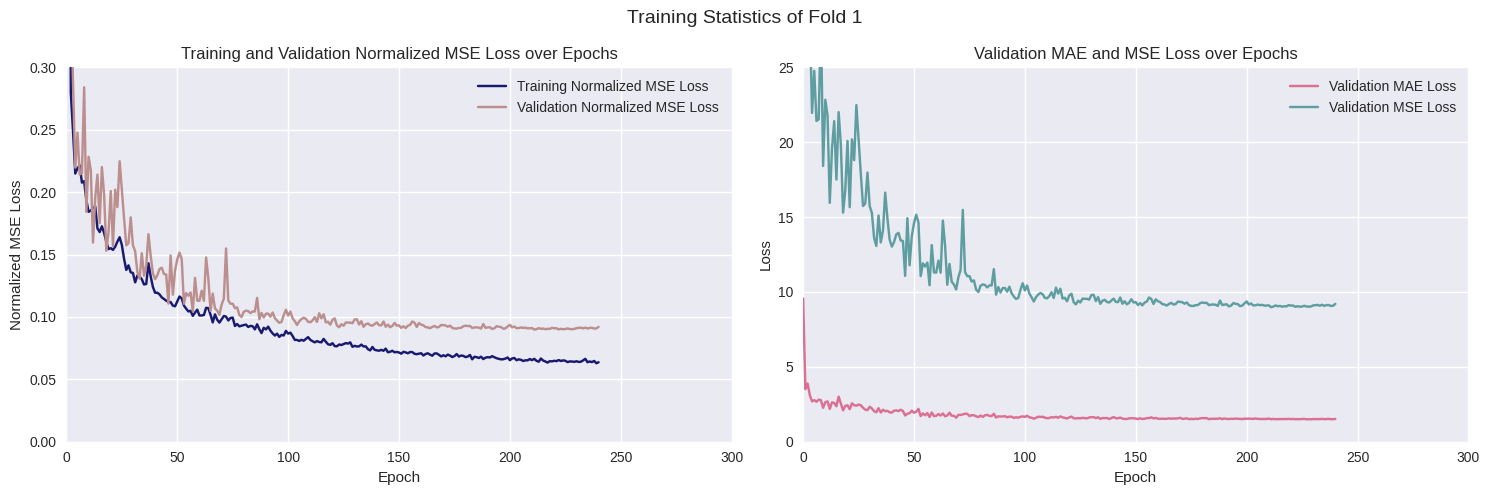

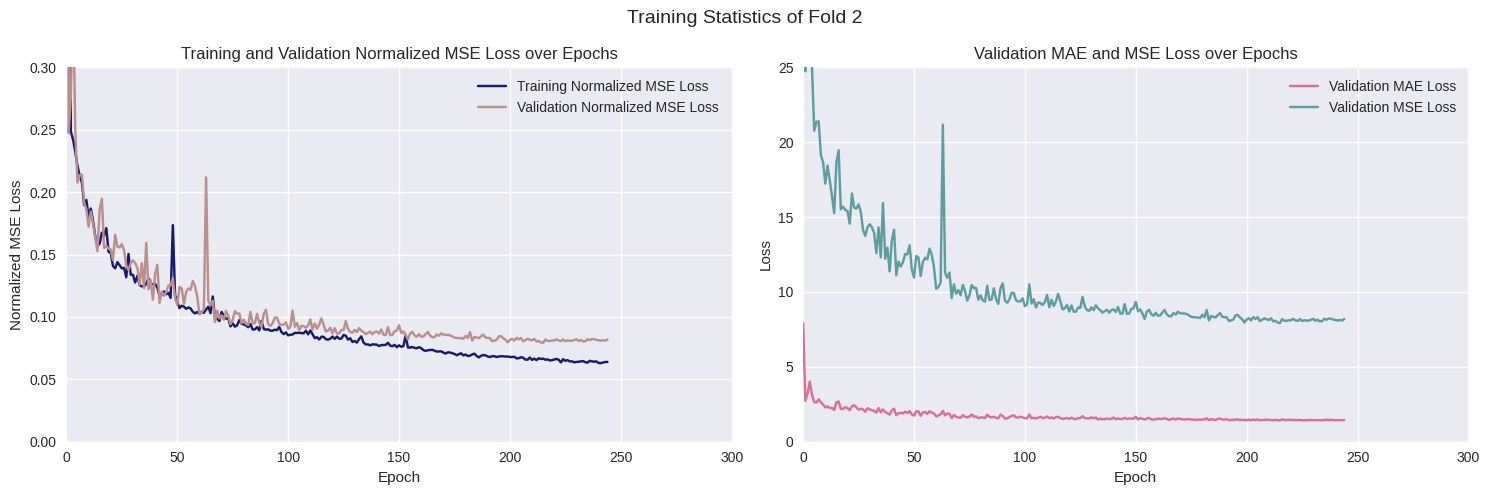

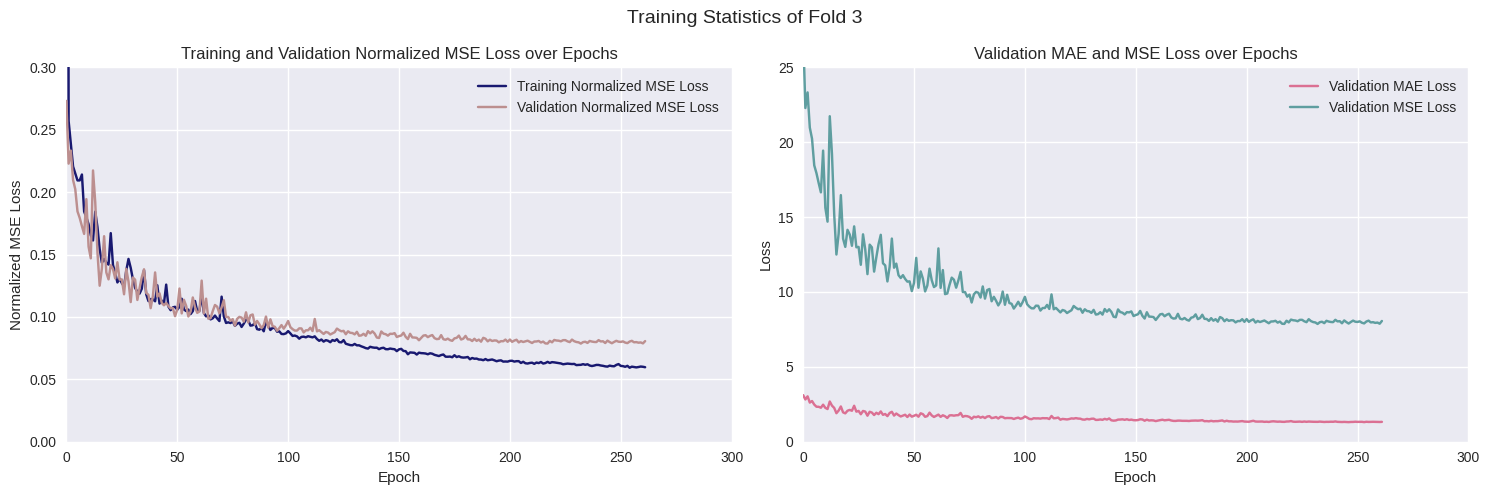

In [58]:
# Used Deepseek to improve aesthetics of the plots
def plot_training_graphs(train_norm_mse_losses, val_norm_mse_losses, val_mae_losses, val_mse_losses):
    global num_folds

    for fold_i in range(num_folds):
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Training Statistics of Fold {fold_i + 1}", fontsize=14)

        plt.style.use("seaborn-v0_8")

        plt.subplot(1, 2, 1)
        plt.title("Training and Validation Normalized MSE Loss over Epochs")
        plt.plot(train_norm_mse_losses[fold_i], label="Training Normalized MSE Loss", color="midnightblue")
        plt.plot(val_norm_mse_losses[fold_i], label="Validation Normalized MSE Loss", color="rosybrown")
        plt.xlabel("Epoch")
        plt.ylabel("Normalized MSE Loss")
        plt.xlim(0, epochs)
        plt.ylim(0, 0.30)
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("Validation MAE and MSE Loss over Epochs")
        plt.plot(val_mae_losses[fold_i], label="Validation MAE Loss", color="palevioletred")
        plt.plot(val_mse_losses[fold_i], label="Validation MSE Loss", color="cadetblue")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.xlim(0, epochs)
        plt.ylim(0, 25)
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_training_graphs(train_norm_mse_losses, val_norm_mse_losses, val_mae_losses, val_mse_losses)

In [59]:
# Make predictions on the test set
model_predictions_df = predict(test_data)
assert len(model_predictions_df) == 126000, f"Incorrect number of rows in output, expected 126000, got {len(model_predictions_df)}"

# Save output in the submission folder, timestamped!
submission_path = os.path.join(submission_dir, f"submission-{get_timestamp()}.csv")
model_predictions_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Submission saved locally as: './submission/submission-2025-06-01_07-14PM.csv'.


# Visualize predictions

These functions are taken from the milestone notebook, with minor additions

In [32]:
def plot_trajectory(ax, pred, gt, title=None):
    plt.style.use("seaborn-v0_8")

    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='palevioletred', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='navy', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [33]:
def visualize_predictions(model, val_dataset, graph_save_path: str = f"{get_timestamp()}_graph.png"):
    global input_features

    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    # randomly select 4 samples from the validation set
    random_indices = random.sample(range(len(val_dataset)), 4)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the array to iterate single axes objects

    for i, idx in enumerate(random_indices):
        batch = val_dataset[idx]
        batch_x, batch_y = None, None
        if isinstance(batch, tuple) or isinstance(batch, list):
            batch_x, batch_y = batch
            X_val_tensor = torch.FloatTensor(batch_x).reshape((-1, input_features)).to(device)
            y_val_tensor = torch.FloatTensor(batch_y.view(-1, 60, 2))

            pred = model(X_val_tensor).cpu().reshape((-1, 60, 2))
            gt = torch.stack(torch.split(y_val_tensor, 60, dim=0), dim=0).squeeze(dim=0) # getting a phantom dimension
        else:
            batch = batch.to(device)
            batch_x = batch.x
            batch_y = batch.y
        
            pred = model(batch_x)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0)

            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

        pred = pred.detach().cpu().numpy()
        gt = gt.detach().cpu().numpy()

        # Plot the trajectory using the i-th axis
        plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

    plt.savefig(fname=graph_save_path)
    plt.show()

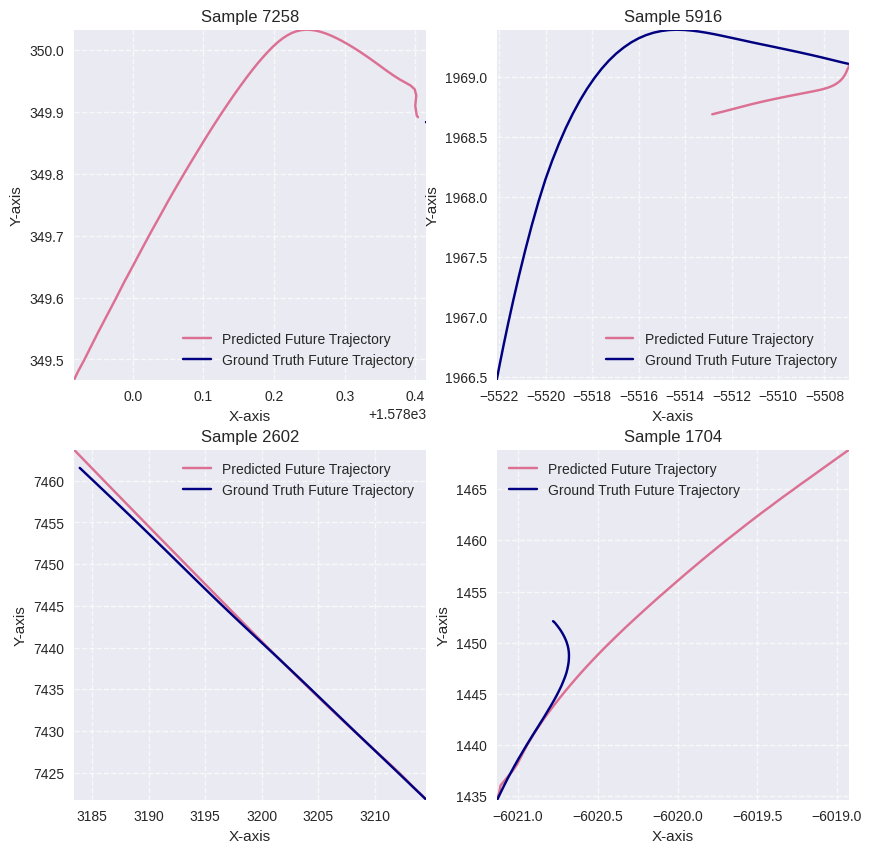

In [34]:
model = get_model()
if not isinstance(model, SceneContextModel):
    # LSTM can handle the timeseries data directly
    # TrajectoryDataset expects numpy arrays
    collate_func = lambda x: Batch.from_data_list(x)
    train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
else:
    train_x: np.ndarray = train_data[..., :50, :]
    train_y: np.ndarray = train_data[:, 0, 50:, :2]
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

visualize_predictions(model, train_dataset)